In [1]:
# import modules
from matrix_utils import targets_ykr_ids, get_travel_times_to_targets, add_min_travel_times_to_df, add_population_to_travel_times, calculate_cumulative_pop, plot_cum_pops 

import glob
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
# read files
cinemas = gpd.read_file('data/cinemas.shp') # CHANGE TARGET SHP HERE
grid = gpd.read_file('data/MetropAccess_YKR_grid_EurefFIN.shp')
ykr_pop = pd.read_csv('data/ykr_pop_join.csv')

In [3]:
# set either small or large cinemas as targets
large_cinemas = cinemas.loc[cinemas['rooms'] > 2]
small_cinemas = cinemas.loc[cinemas['rooms'] <= 2]
targets = large_cinemas.reset_index()
# print(targets[['name', 'rooms', 'seats', 'city']])

In [4]:
# get ykr_ids, names and timecols for targets
target_info = targets_ykr_ids(grid, targets)
print(target_info)

CRS match: True
YKR ids: [5879925, 5975376, 5978593, 5936704, 5975372]
{'ykr_ids': [5879925, 5975376, 5978593, 5936704, 5975372], 'timecols': ['pt_r_t_0', 'pt_r_t_1', 'pt_r_t_2', 'pt_r_t_3', 'pt_r_t_4'], 'names': ['FLAMINGO', 'KINOPALATSI', 'OMENA', 'SELLO', 'TENNISPALATSI']}


In [5]:
# get traveltimes 2015 to targets 
folder15 = 'data/HelsinkiRegion_TravelTimeMatrix2015/'
ttimes15 = get_travel_times_to_targets(grid, target_info['ykr_ids'], folder15)
ttimes15 = add_min_travel_times_to_df(ttimes15)
ttimes_pop_15 = add_population_to_travel_times(ttimes15, ykr_pop)
cum_pops_15 = calculate_cumulative_pop(ttimes_pop_15, 'min_t')

dropped 211 rows with na values


/Users/joose/Documents/hy/qmslup-poster/matrix_utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ttimes['min_t'] = [int(value) for value in ttimes['min_t']]


In [6]:
ttimes15.head(2)
ttimes_pop_15.head(2)

,YKR_ID,geometry,pt_r_t_0,pt_r_t_1,pt_r_t_2,pt_r_t_3,pt_r_t_4,min_t,min_idx,ASUKKAITA
0,5787548,"POLYGON ((382250.0001387566 6697500.000128225,...",115.0,118.0,147.0,118.0,118.0,115,pt_r_t_0,10
1,5791356,"POLYGON ((381000.0001390452 6697000.000128352,...",60.0,68.0,91.0,68.0,67.0,60,pt_r_t_0,13


In [7]:
# get traveltimes 2018 to targets 
folder18 = 'data/HelsinkiTravelTimeMatrix2018/'
ttimes18 = get_travel_times_to_targets(grid, target_info['ykr_ids'], folder18)
ttimes18 = add_min_travel_times_to_df(ttimes18)
ttimes_pop_18 = add_population_to_travel_times(ttimes18, ykr_pop)
cum_pops_18 = calculate_cumulative_pop(ttimes_pop_18, 'min_t')
ttimes18.head(2)

dropped 127 rows with na values


/Users/joose/Documents/hy/qmslup-poster/matrix_utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ttimes['min_t'] = [int(value) for value in ttimes['min_t']]


,YKR_ID,geometry,pt_r_t_0,pt_r_t_1,pt_r_t_2,pt_r_t_3,pt_r_t_4,min_t,min_idx
0,5785640,"POLYGON ((382000.0001388059 6697750.000128186,...",103.0,115.0,144.0,122.0,115.0,103,pt_r_t_0
1,5785641,"POLYGON ((382250.00013875 6697750.000128181, 3...",106.0,118.0,147.0,125.0,118.0,106,pt_r_t_0


In [8]:
# merge 2015 & 2018 travel times and add min time difference
mergecols = ['YKR_ID', 'min_t', 'min_idx']
min_times_diff_18_15 = pd.merge(ttimes15, ttimes18[mergecols], how='inner', on='YKR_ID',\
                                suffixes=('_15', '_18'))
min_times_diff_18_15['dif_18-15'] = min_times_diff_18_15.apply(lambda row: row['min_t_18']-row['min_t_15'], axis=1)
min_times_diff_18_15.head(2)

,YKR_ID,geometry,pt_r_t_0,pt_r_t_1,pt_r_t_2,pt_r_t_3,pt_r_t_4,min_t_15,min_idx_15,min_t_18,min_idx_18,dif_18-15
0,5785640,"POLYGON ((382000.0001388059 6697750.000128186,...",99.0,112.0,141.0,112.0,112.0,99,pt_r_t_0,103,pt_r_t_0,4
1,5785641,"POLYGON ((382250.00013875 6697750.000128181, 3...",112.0,115.0,143.0,115.0,115.0,112,pt_r_t_0,106,pt_r_t_0,-6


In [9]:
# export 2015 travel times (large cinemas) to SHP
# ttimes15.to_file('results/tt_closest_large_15.shp')
# ttimes_pop_18.to_file('results/tt_closest_large_pop_15.shp')

In [10]:
# export 2018 travel times (large cinemas) to SHP
# ttimes18.to_file('results/tt_closest_large_18.shp')
# ttimes_pop_18.to_file('results/tt_closest_large_pop_18.shp')

In [11]:
# export 2018-2015 difference to SHP
# min_times_diff_18_15.to_file('results/tt_closest_large_diff_18_15.shp')

In [12]:
# export cum pops as csv
cum_pops_18.to_csv('results/cum_pops_18.csv', encoding='utf-8', index=False)
cum_pops_15.to_csv('results/cum_pops_15.csv', encoding='utf-8', index=False)

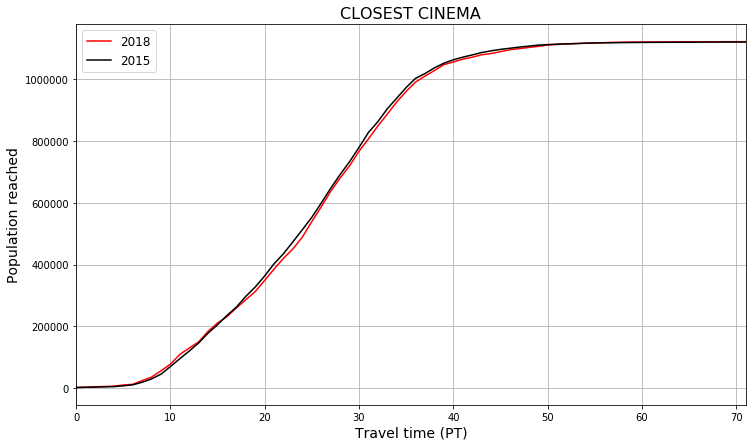

In [13]:
# PLOTS
import matplotlib.pyplot as plt

# prepare fig & ax for plotting
fig, ax = plt.subplots(figsize=(12,7))

# plot data
ax.plot(cum_pops_18['time'], cum_pops_18['cumpopulation'], c='red', label='2018')
ax.plot(cum_pops_15['time'], cum_pops_15['cumpopulation'], c='black', label='2015')

# set labels
ax.set(xlabel='Travel time (PT)', ylabel='Population reached')
ax.set_title('CLOSEST CINEMA', fontsize=16)

# set axis & ticks
ax.set_xlim([0,71])
ax.grid()
# ticks every 10
x_ticks = np.arange(0, 71, 10)
#y_ticks = np.arange(0, 1110000, 100000)
ax.set_xticks(x_ticks)
#ax.set_yticks(y_ticks)

# set font size
plt.rcParams.update({'font.size': 12})
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# add legend
ax.legend()

# save plot
fig.savefig('plots/cum_pop_CLOSEST.png', dpi=150)
# fig.savefig('plots/pop_curve_test.eps', format='eps', dpi=1000)

# show plot
plt.show()

pt_r_t_0
0


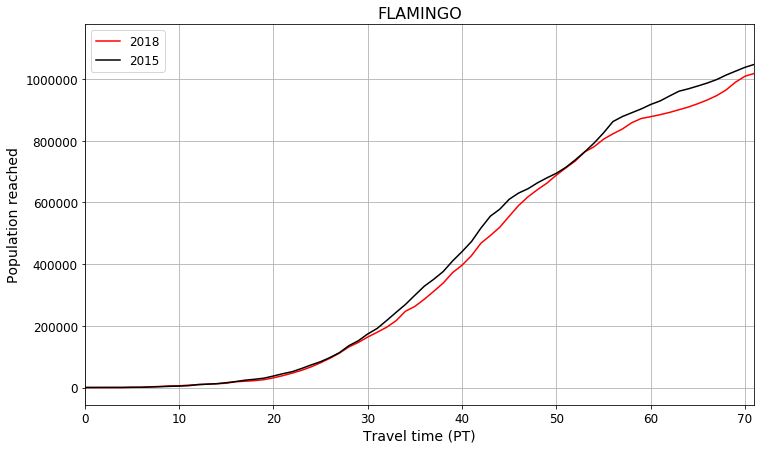

pt_r_t_1
1


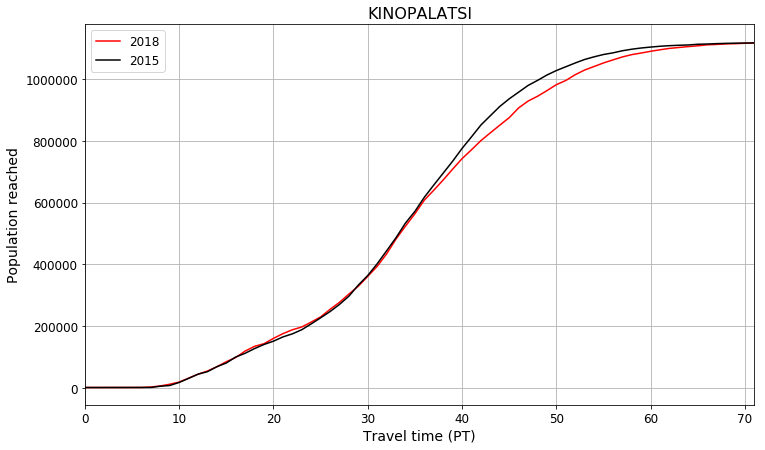

pt_r_t_2
2


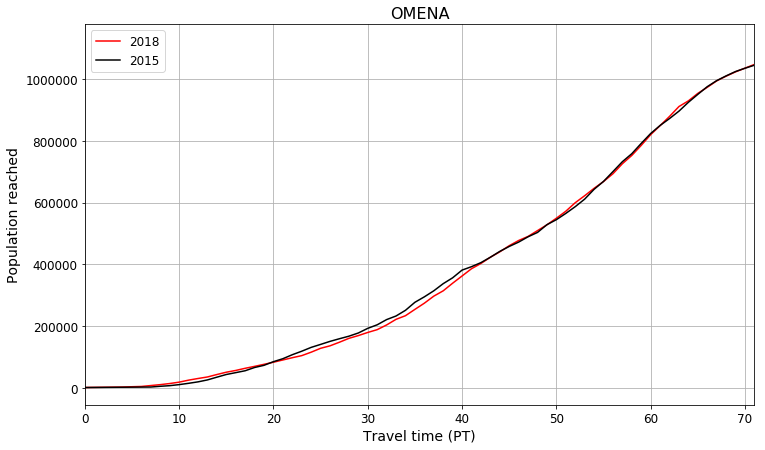

pt_r_t_3
3


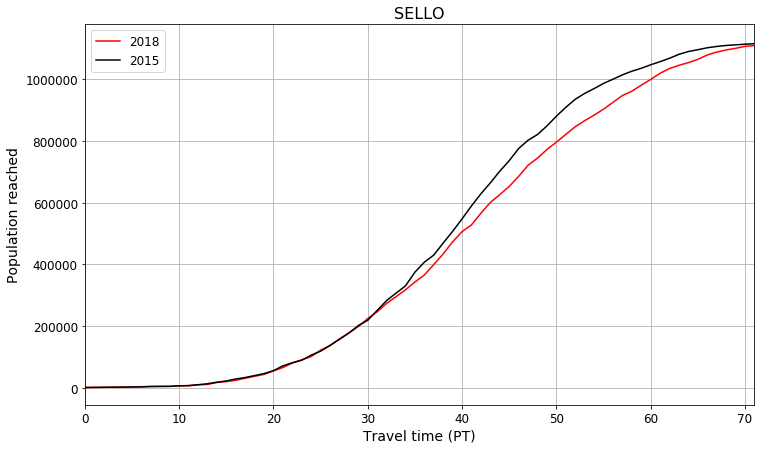

pt_r_t_4
4


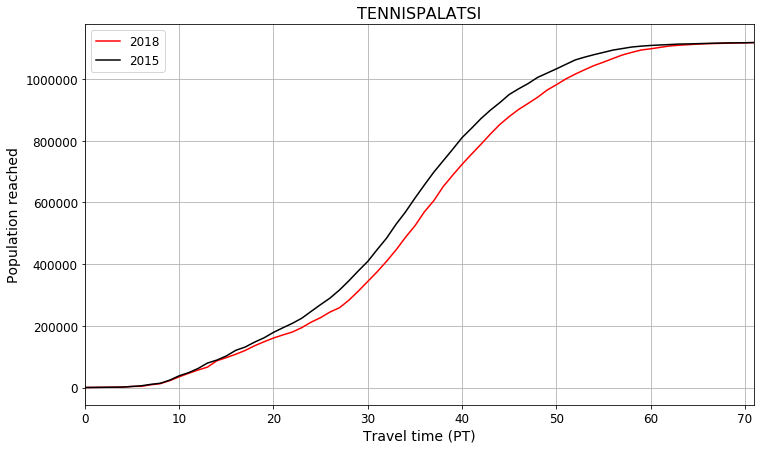

In [14]:
# calculate cumulative populations to cinemas separately and save plots

for idx, timecol in enumerate(target_info['timecols']):
    print(timecol)
    print(idx)
    cum_pops_15 = calculate_cumulative_pop(ttimes_pop_15, timecol)
    cum_pops_18 = calculate_cumulative_pop(ttimes_pop_18, timecol)
    plot_cum_pops(cum_pops_15, cum_pops_18, idx, target_info)
